In [1]:
from glob import glob
from os.path import join
from os import environ
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import nengo
import nengo_dl
import nengo_loihi

from nxsdk.graph.monitor.probes import PerformanceProbeCondition
from nxsdk.api.n2a import ProbeParameter

# All Nengo Loihi models should call this before model construction
nengo_loihi.set_defaults() #changes default neuron parameters for better performance on Loihi

# To provide repeatable behavior
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
def LoadModel(name="classifier"):
    structure = Path(name+"Structure.json").read_text()
    model = keras.models.model_from_json(structure)
    model.load_weights(name+"Weights.h5")
    return model

def LoadData(batchNum=0, directory="Development"):
    fileList = glob(join("Dataset", directory, "test*"))
    dataBatch = np.load(fileList[batchNum])
    return dataBatch["data"], dataBatch["isFace"], dataBatch["labels"]

In [3]:
data, isFace, labels = LoadData(directory="Training")
data = data.astype('float32') / 255

model = LoadModel()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 31, 16)        432       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 8)         1152      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 4)           288       
_________________________________________________________________
flatten (Flatten)            (None, 196)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 197       
Total params: 2,069
Trainable params: 2,069
Non-trainable params: 0
___________________________________________________________

In [4]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.evaluate(data, isFace) #get loss and accuracy over test data

26/26 [==============================] - 0s 5ms/step - loss: 0.1790 - accuracy: 0.9841


[0.17899900674819946, 0.9841075539588928]

In [5]:
subset = data[:10]
predictions = model.predict(subset)[:,0]
print("Prediction: ", predictions)
print("ground truth: ", isFace[:10])

Prediction:  [3.3255105  3.3052843  0.81340384 7.0870447  1.8715216  2.8892748
 2.7007937  1.264092   7.6157885  4.796785  ]
ground truth:  [1 1 1 1 1 1 1 1 1 1]


In [6]:
print("Prediction: ", model.predict(data[-10:])[:,0])
print("ground truth: ", isFace[-10:])

Prediction:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ground truth:  [0 0 0 0 0 0 0 0 0 0]


In [7]:
activation = keras.activations.relu

# Convert to spiking network
nengo_converter = nengo_dl.Converter(model,
                                     swap_activations={activation: nengo_loihi.neurons.LoihiSpikingRectifiedLinear()},
                                     scale_firing_rates=100, synapse=0.005)
snnNet = nengo_converter.net

In [8]:
inLayer = model.layers[0]
firstConv = model.layers[1]
outLayer = model.layers[-1]

In [9]:
#add spike probes to network
with snnNet:
    outProbe = nengo.Probe(snnNet.all_ensembles[-1], synapse=nengo.Alpha(0.05))
    
    #set input to Simulator
    nengo_converter.inputs[inLayer].output = nengo.processes.PresentInput([subset[0]], 1)
    
    nengo_loihi.add_params(snnNet)  # allow on_chip to be set
    snnNet.config[nengo_converter.layers[firstConv].ensemble].on_chip = False

snnNet.all_objects

[<Ensemble "conv2d.0" at 0x7f69a84f88d0>,
 <Ensemble "conv2d_1.0" at 0x7f69a84f8b70>,
 <Ensemble "conv2d_2.0" at 0x7f69a84f8e80>,
 <Ensemble "dense.0" at 0x7f69a83da208>,
 <Node "input_1" at 0x7f69a84f87b8>,
 <Probe at 0x7f69a83da828 of 'output' of <Neurons of <Ensemble "dense.0">>>,
 <Probe at 0x7f69a83dad30 of 'decoded_output' of <Ensemble "dense.0">>,
 <Connection at 0x7f69a84f8a20 from <Node "input_1"> to <Neurons of <Ensemble "conv2d.0">>>,
 <Connection at 0x7f69a84f8cc0 from <Neurons of <Ensemble "conv2d.0">> to <Neurons of <Ensemble "conv2d_1.0">>>,
 <Connection at 0x7f69a84f8fd0 from <Neurons of <Ensemble "conv2d_1.0">> to <Neurons of <Ensemble "conv2d_2.0">>>,
 <Connection at 0x7f69a83da278 from <Neurons of <Ensemble "conv2d_2.0">> to <Neurons of <Ensemble "dense.0">>>]

In [10]:
run_time = 1
dt = 0.001

with nengo.Simulator(snnNet, dt=dt) as cpuSim:
    cpuSim.run(run_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

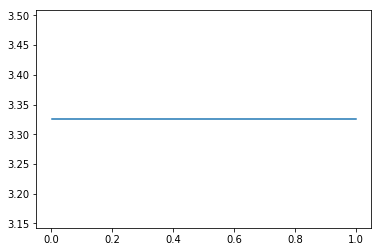

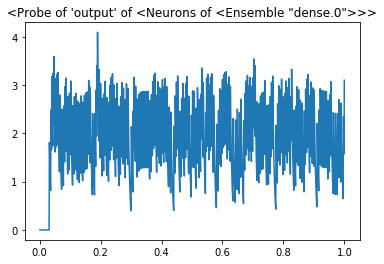

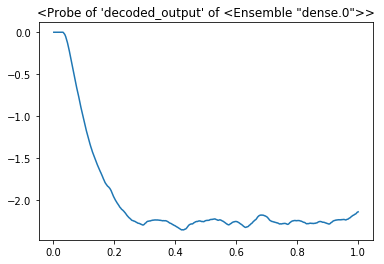

In [11]:
timeAx = cpuSim.trange()

#Plot non-spiking output
plt.figure()
plt.plot(timeAx, np.repeat(predictions[0], int(1/dt)))

for probe in snnNet.probes:
    plt.figure()
    plt.plot(timeAx, cpuSim.data[probe])
    plt.title(probe)

In [47]:
# environ["PARTITION"] = "nahuku32"

sim = nengo_loihi.Simulator(snnNet, dt=dt)
board = sim.sims["loihi"].nxsdk_board
probe_cond = PerformanceProbeCondition(
    tStart=1, tEnd=int(run_time / dt), bufferSize=1024, binSize=4
)
e_probe = board.probe(ProbeParameter.ENERGY, probe_cond)

# print information about how cores are being utilized
print("\n".join(sim.model.utilization_summary()))

with sim:
    sim.run(run_time)

LoihiBlock(<Ensemble "conv2d_1.0">[0:900:1]): 87.9% compartments, 12.2% in-axons, 5.5% out-axons, 17.3% synapses
LoihiBlock(<Ensemble "conv2d_1.0">[900:1800:1]): 87.9% compartments, 12.2% in-axons, 5.5% out-axons, 17.7% synapses
LoihiBlock(<Ensemble "conv2d_2.0">): 19.1% compartments, 5.5% in-axons, 4.8% out-axons, 1.2% synapses
LoihiBlock(<Ensemble "dense.0">): 0.1% compartments, 4.8% in-axons, 0.0% out-axons, 1.2% synapses
LoihiBlock(<Connection from <Ensemble "dense.0"> to <Probe of 'decoded_output' of <Ensemble "dense.0">>>): 0.2% compartments, 0.0% in-axons, 0.0% out-axons, 0.0% synapses
Average (5 blocks): 39.0% compartments, 6.9% in-axons, 3.2% out-axons, 7.5% synapses
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.104:44227
INFO:DRV:      Host server up..............Done 0.22s
INFO:DRV:      Encoding axons/synapses.....Done 0.24s
INFO:DRV:      Compiling Embedded snips....Done 0.25s
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connectin

Text(0.5,1,'<Probe of \'output\' of <Neurons of <Ensemble "dense.0">>>')

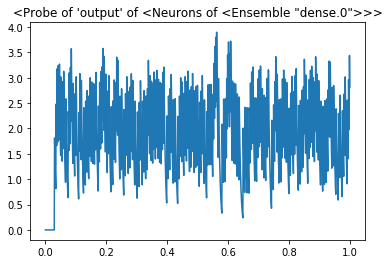

In [39]:
plt.plot(sim.trange(), sim.data[snnNet.probes[0]])
plt.title(snnNet.probes[0])

Text(0.5,1,'<Probe of \'decoded_output\' of <Ensemble "dense.0">>')

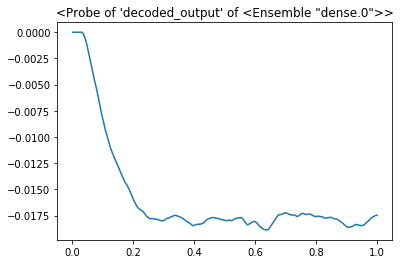

In [40]:
plt.plot(sim.trange(), sim.data[snnNet.probes[1]])
plt.title(snnNet.probes[1])

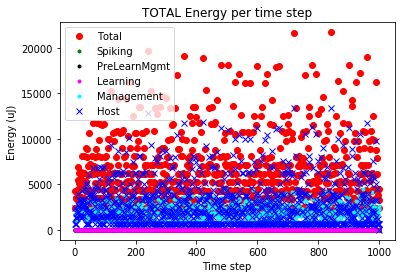

In [41]:
e_probe.plotEnergy()

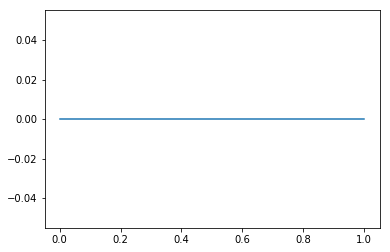

In [42]:
plt.plot(sim.trange(), e_probe.spikingPhaseEnergyPerTimeStep)

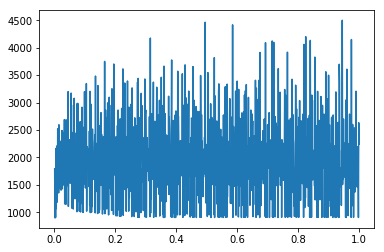

In [43]:
plt.plot(sim.trange(), e_probe.managementPhaseEnergyPerTimeStep)

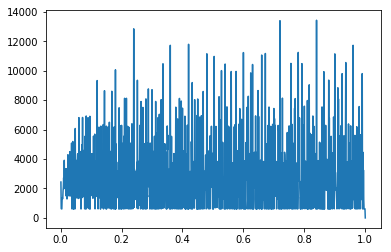

In [44]:
plt.plot(sim.trange(), e_probe.hostPhaseEnergyPerTimeStep)